In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

%matplotlib inline
plt.ion()

In [2]:
# Data sugmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train':transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val':transforms.Compose([
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../data/Images'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                       data_transforms[x])
                for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle = True, num_workers=4)
              for x in ['train','val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
torch.cuda.is_available()

True

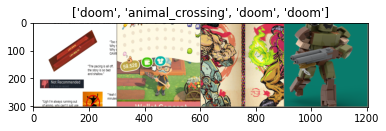

In [4]:
def imshow(inp, title = None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    results = {"train": {"loss" : [], "acc": []},\
               "val": {"loss" : [], "acc": []}}
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train','val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase=='train'):
                    
                    if phase == 'train':
                        outputs = model(inputs)[0]
                    else:
                        outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            results[phase]["loss"].append(epoch_loss)
            results[phase]["acc"].append(epoch_acc)
            
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            #deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best val Acc: {:4f}".format(best_acc))
    
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, results

In [6]:
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs[0], 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title("predicted: {}".format(class_names[preds[j]]))
                imshow(inputs.cpu(). data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:
model_ft = models.inception_v3(pretrained = True)

num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [12]:
model_ft, model_results = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5817 Acc: 0.6957
val Loss: 0.4232 Acc: 0.7888

Epoch 1/24
----------
train Loss: 0.5109 Acc: 0.7632
val Loss: 0.4736 Acc: 0.7453

Epoch 2/24
----------
train Loss: 0.5173 Acc: 0.7639
val Loss: 0.4111 Acc: 0.7702

Epoch 3/24
----------
train Loss: 0.4545 Acc: 0.8001
val Loss: 0.4756 Acc: 0.7578

Epoch 4/24
----------
train Loss: 0.4403 Acc: 0.8036
val Loss: 0.4719 Acc: 0.7764

Epoch 5/24
----------
train Loss: 0.4179 Acc: 0.8036
val Loss: 0.6414 Acc: 0.7019

Epoch 6/24
----------
train Loss: 0.4315 Acc: 0.7974
val Loss: 0.3654 Acc: 0.8323

Epoch 7/24
----------
train Loss: 0.3845 Acc: 0.8350
val Loss: 0.3593 Acc: 0.8323

Epoch 8/24
----------
train Loss: 0.3668 Acc: 0.8322
val Loss: 0.3724 Acc: 0.8137

Epoch 9/24
----------
train Loss: 0.3645 Acc: 0.8308
val Loss: 0.3634 Acc: 0.8199

Epoch 10/24
----------
train Loss: 0.3500 Acc: 0.8468
val Loss: 0.3716 Acc: 0.8137

Epoch 11/24
----------
train Loss: 0.3042 Acc: 0.8670
val Loss: 0.3648 Acc: 0.8199

Ep

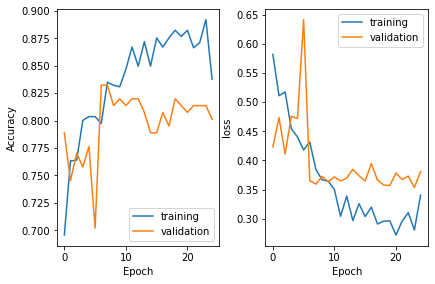

In [13]:
fig, axs = plt.subplots(nrows = 1, ncols = 2)
fig.tight_layout(pad=1.5)

for i in range(2):
    if i == 0:
        val = "acc"
    else:
        val = "loss"
    axs[i].plot(model_results["train"][val], label='training')
    axs[i].plot(model_results["val"][val], label = "validation")

axs[0].set(xlabel='Epoch',ylabel='Accuracy')
axs[1].set(xlabel='Epoch',ylabel='loss')
axs[0].legend()
axs[1].legend()

plt.savefig('inception.png', dpi=300)

In [14]:
model_ft = models.inception_v3(pretrained = True)

num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [16]:
model_ft, model_results = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6082 Acc: 0.6650
val Loss: 0.5366 Acc: 0.7205

Epoch 1/24
----------
train Loss: 0.5874 Acc: 0.6999
val Loss: 0.5569 Acc: 0.7081

Epoch 2/24
----------
train Loss: 0.5973 Acc: 0.7145
val Loss: 0.4456 Acc: 0.7640

Epoch 3/24
----------
train Loss: 0.5661 Acc: 0.7382
val Loss: 0.4389 Acc: 0.7764

Epoch 4/24
----------
train Loss: 0.5683 Acc: 0.7235
val Loss: 0.4384 Acc: 0.7702

Epoch 5/24
----------
train Loss: 0.6180 Acc: 0.7096
val Loss: 0.6071 Acc: 0.7143

Epoch 6/24
----------
train Loss: 0.6362 Acc: 0.7131
val Loss: 0.4918 Acc: 0.7516

Epoch 7/24
----------
train Loss: 0.5235 Acc: 0.7563
val Loss: 0.4518 Acc: 0.7640

Epoch 8/24
----------
train Loss: 0.5313 Acc: 0.7416
val Loss: 0.4178 Acc: 0.8012

Epoch 9/24
----------
train Loss: 0.5390 Acc: 0.7604
val Loss: 0.4389 Acc: 0.7702

Epoch 10/24
----------
train Loss: 0.5293 Acc: 0.7500
val Loss: 0.3933 Acc: 0.8012

Epoch 11/24
----------
train Loss: 0.5389 Acc: 0.7444
val Loss: 0.4072 Acc: 0.8012

Ep

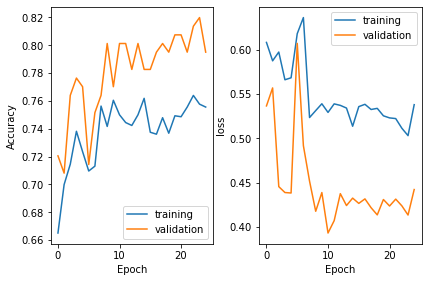

In [17]:
fig, axs = plt.subplots(nrows = 1, ncols = 2)
fig.tight_layout(pad=1.5)

for i in range(2):
    if i == 0:
        val = "acc"
    else:
        val = "loss"
    axs[i].plot(model_results["train"][val], label='training')
    axs[i].plot(model_results["val"][val], label = "validation")

axs[0].set(xlabel='Epoch',ylabel='Accuracy')
axs[1].set(xlabel='Epoch',ylabel='loss')
axs[0].legend()
axs[1].legend()

plt.savefig('inceptionFC.png', dpi=300)